# Forest 3: Merge Forest with Fire and Approximate Age
Disclaimer, please read through Forest 1 and Forest 2.
## Overview of Notebook
This notebook takes the compiled Ontario Forest Data within the Ontario boundary, and outputs a final dataframe that is modified to make better used of the data in the dataframe.

## 1) Import Modules and Packages

In [1]:
import os

import pandas as pd

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## 2) Get Path and Data
Here we will open both the Ontario Forest Data DataFrame and the Ontario Boundary shapfile. The latter will be used as a visual tool for plotting when needed.

In [2]:
path = r"I:\CME538 Project\processed data ontario only\250m"

In [ ]:
os.listdir(path)

['Approximations',
 'ONage2001_250m',
 'ONage2001_250m.tif',
 'ONage2001_250m.tif.aux.xml',
 'ONage2011_250m',
 'ONage2011_250m.tif',
 'ONage2011_250m.tif.aux.xml',
 'Onage2019_250m',
 'Onage2019_250m.tif',
 'Onage2019_250m.tif.aux.xml',
 'ONharvest1985_2020_250m',
 'ONharvest1985_2020_250m.tif',
 'ONharvest1985_2020_250m.tif.aux.xml',
 'Ontario_fire_in_forest_coordinates.csv.gz',
 'Ontario_Forest_Data.csv.gz',
 'Ontario_Forest_Data_Points.csv.gz',
 'ONvol2001_250m',
 'ONvol2001_250m.tif',
 'ONvol2001_250m.tif.aux.xml',
 'ONvol2011_250m',
 'ONvol2011_250m.tif',
 'ONvol2011_250m.tif.aux.xml',
 'ONvol2015_250m',
 'ONvol2015_250m.tif',
 'ONvol2015_250m.tif.aux.xml',
 'ON_forest_and_fires.csv.gz']

In [ ]:
filenames = os.listdir(path)[12:15]
filenames

In [ ]:
ON_boundary = gpd.read_file(r"I:\CME538 Project\CME538 Project\ontario boundary\Province\Province.shp")

In [ ]:
ON_boundary = ON_boundary.to_crs(4269)

In [ ]:
ON_boundary.plot()

In [ ]:
ON_forest = pd.read_csv(path+"\\"+filenames[2],compression='gzip',index_col=0)
ON_forest.head()

In [ ]:
ON_forest.info()

We can acually drop the lat and lon columns for the poly shape (the last 8 columns) 

In [ ]:
ON_forest.drop(columns=['lon1','lon2','lon3','lon4','lat1','lat2','lat3','lat4'],inplace=True)

In [ ]:
ON_fire = pd.read_csv(path+"\\"+filenames[0],index_col=0)
ON_fire.head()

In [ ]:
ON_fire.info()

## 3) Exploring and Modifying the Fire Data 

The ON_fire dataframe consists of fire data that were spatially joined to our current forest pixel grid. This one done sjoinging the forest data onto the fire data. A buffer polygon was created based on the area of the fire, centered at its cendroid. Then the joinging was done to see how many of our 250mx250m pixels coordinates intersected with the fire area polygon. We can now map the fires based on there areas on our coordinate grid. 

So the important geometry to keep for the ON_fire data is the last geometry column, which is the same grid as our fores data.

In [ ]:
ON_fire.columns

We can get rid of some columns that we may not need like:
- Unamed: 0
- point_geometry
- buffer_geometry
- buffer_radius
- index_right

In [ ]:
ON_fire.drop(columns=['point_geometry', 'buffer_radius', 'buffer_geometry'],inplace=True)

Let rename the lat,lon, LATITUDE and LONGITUDE columns to something better, and uncapitalize all the columns

In [ ]:
ON_fire.rename(columns={"LATITUDE":'original_lat',"LONGITUDE":'original_lon'},inplace=True)
ON_fire.columns = ON_fire.columns.str.lower()
ON_fire.head()

## 4) Merging Forest and Fire DataSets

Now we have two data sets:
1) ON_forest, crs = 4269
2) ON_fire, crs = 3347

We want to merge the fire data to the forest data. But first, we need to do some manipulation on the fire data. The column 'index' has a unique number associated with each fire, so we can check how many fires there are

In [ ]:
print("There are {} unique fires".format(ON_fire['index'].nunique()))
print("But there are {} row in the ON_fire data".format(len(ON_fire)))

This checks out, there were 20866 fire in our original datasets and we have 20595. We have lost a few fires because some may have been errors or on lake or boundary edges. But there are over 500000 rows in our dataset! that is because some fire cover many 250mx250m pixel. We are not worried about duplication here because out grid matched our forest grid.

We are however interested in any data that has duplicate fires that happened in the same year or different years at the same location. Lets filter the dataframe to see how this looks.

In [ ]:
ON_fire[ON_fire.duplicated('pixel_geometry',keep=False)]

Here we can see that we have ducplicate columns, because multiple fires were reported arround this coordinate. For example, the first two rows (index = 96800) had a fire reported late july and early augus. 

Another case (index= 98679) show a fire in 2011 and 2016. 

For simplicity, if there are two fires reported in the same year, we will assume that only one occured. 

If there are multiple fires reported for different years, we need to figure out a way to deal with this.

Let filter out all the unnessecarry information at this stage. We are only interested about the date of the fire and the locaiton (geometry)

In [ ]:
#ON_fire.rename(columns={'pixel_geometry':'geometry'},inplace=True)
ON_fire = ON_fire[['year','month','day','area_intersect_perc']]
ON_fire.head()

Now lets create a funciton that will return an array of dates for each coordinates that can have multiple fires reported

In [ ]:
unique_index_duplicate = ON_fire.index.unique()
year = []
month = []
day = []
area_perc = []

def get_duplicate_fire_dates(data):
    """
    """
    year,month,day,area= [],[],[],[]
    if isinstance(data,pd.Series) == True:
        year.append(int(data[0]))
        month.append(int(data[1]))
        day.append((data[2]))
        area.append((data[3]))
    
    else:
        for i in range(len(data)):
            year.append((data.iloc[i,0]))
            month.append((data.iloc[i,1]))
            day.append((data.iloc[i,2]))
            area.append((data.iloc[i,3]))
        
    return year,month,day,area

for ind in unique_index_duplicate:
    
    year_temp,month_temp,day_temp,area_temp= get_duplicate_fire_dates(ON_fire.loc[ind][:])
    
    year.append(year_temp)
    month.append(month_temp)
    day.append(day_temp)
    area_perc.append(area_temp)

Check that our returned arrays are same length as the number of unique rows in ON_fire

In [ ]:
print("length of year: {} month: {} day: {} and area: {} match the number of unique rows in ON_fire: {}".format(len(year),len(month),len(day),len(area_perc),len(ON_fire.index.unique())))

Now lets filter the ON_fire data to the just the unique rows and replace the year month and day columns with our arrays

In [ ]:
ON_fire=ON_fire[~ON_fire.index.duplicated()]
ON_fire.year = year
ON_fire.month = month
ON_fire.day = day
ON_fire.area_intersect_perc = area_perc
ON_fire

No we can join the ON_fire to the ON_forest data frame on the index, which is a unique code for each pixel. Lets create a new dataframe called ON_forest_and_fires

In [ ]:
ON_forest_and_fires = ON_forest.join(ON_fire,lsuffix=" ")

In [ ]:
ON_forest_and_fires.head()

lets take a look and see how non nan rows look

In [ ]:
ON_forest_and_fires[~ON_forest_and_fires.year.isna()]

We can also take a look at the rows which have multiple fires lets add a column called number_fires

In [ ]:
ON_forest_and_fires['number_fires'] = ON_forest_and_fires[~ON_forest_and_fires.year.isna()].year.apply(lambda row: len(row))

Lets also see what the max number of fires is and lets see what having more then 10 fires on a pixel looks like

In [ ]:
ON_forest_and_fires.number_fires.unique()

In [ ]:
ON_forest_and_fires[ON_forest_and_fires.number_fires > 10]

In [ ]:
ON_forest_and_fires.head()

In [ ]:
ON_forest_and_fires[(~ON_forest_and_fires.year.isna()) & (ON_forest_and_fires.number_fires > 1)].head()

Everything looks good. Lets go ahead and save it to our drive as a safekeep.

In [ ]:
ON_forest_and_fires.to_csv(path+"\\"+"ON_forest_and_fires.csv.gz",compression='gzip',header=ON_forest_and_fires.columns)

## 5) Exploring the Data
Lets take a look at some of the columns. We have two main categories, aside from the harvest years columns; (1) the age of forests and (2) the volume density of forests in Ontario. For each catergory, we have three points in time. 

Lets take a look at how this data looks. To make visualization easier, lets only look that the rows without nan value.

### 5 alternate) Only do cell 179 to 181 if you need to re-import the data

In [3]:
ON_forest_and_fires = pd.read_csv(path+"\\"+"ON_forest_and_fires.csv.gz",compression='gzip',index_col=0)
ON_forest_and_fires.head()

C:\Users\Antoine Pepin\AppData\Local\Temp\ipykernel_4252\1282596975.py:1: DtypeWarning: Columns (11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  ON_forest_and_fires = pd.read_csv(path+"\\"+"ON_forest_and_fires.csv.gz",compression='gzip',index_col=0)


,age_2001,age_2011,age_2019,year_harvested,vol_2001,vol_2011,vol_2015,lon,lat,geometry,year,month,day,area_intersect_perc,number_fires
0,104.0,NaN,NaN,NaN,8.55,NaN,NaN,-84.890501,46.906052,POLYGON ((-84.88863710751139 46.90697579711416...,NaN,NaN,NaN,NaN,NaN
1,104.0,NaN,NaN,NaN,8.55,NaN,NaN,-84.885743,46.912303,POLYGON ((-84.88387922029249 46.91322718112671...,NaN,NaN,NaN,NaN,NaN
2,104.0,NaN,NaN,NaN,8.55,NaN,NaN,-84.887410,46.919261,POLYGON ((-84.88554623463179 46.92018483757417...,NaN,NaN,NaN,NaN,NaN
3,104.0,NaN,NaN,NaN,8.55,NaN,NaN,-84.884197,46.918908,POLYGON ((-84.88233307531861 46.91983171613633...,NaN,NaN,NaN,NaN,NaN
4,57.0,NaN,NaN,NaN,38.69,NaN,NaN,-84.748565,46.962634,POLYGON ((-84.74669588337325 46.96355596569322...,NaN,NaN,NaN,NaN,NaN


In [4]:
ON_forest_and_fires['year']=ON_forest_and_fires.year.str.strip("][")
ON_forest_and_fires['year']=ON_forest_and_fires.year.str.split(", ")
ON_forest_and_fires['month']=ON_forest_and_fires.month.str.strip("][")
ON_forest_and_fires['month']=ON_forest_and_fires.month.str.split(", ")
ON_forest_and_fires['day']=ON_forest_and_fires.day.str.strip("][")
ON_forest_and_fires['day']=ON_forest_and_fires.day.str.split(", ")
ON_forest_and_fires['area_intersect_perc']=ON_forest_and_fires.area_intersect_perc.str.strip("][")
ON_forest_and_fires['area_intersect_perc']=ON_forest_and_fires.area_intersect_perc.str.split(", ")
ON_forest_and_fires.head()

,age_2001,age_2011,age_2019,year_harvested,vol_2001,vol_2011,vol_2015,lon,lat,geometry,year,month,day,area_intersect_perc,number_fires
0,104.0,NaN,NaN,NaN,8.55,NaN,NaN,-84.890501,46.906052,POLYGON ((-84.88863710751139 46.90697579711416...,NaN,NaN,NaN,NaN,NaN
1,104.0,NaN,NaN,NaN,8.55,NaN,NaN,-84.885743,46.912303,POLYGON ((-84.88387922029249 46.91322718112671...,NaN,NaN,NaN,NaN,NaN
2,104.0,NaN,NaN,NaN,8.55,NaN,NaN,-84.887410,46.919261,POLYGON ((-84.88554623463179 46.92018483757417...,NaN,NaN,NaN,NaN,NaN
3,104.0,NaN,NaN,NaN,8.55,NaN,NaN,-84.884197,46.918908,POLYGON ((-84.88233307531861 46.91983171613633...,NaN,NaN,NaN,NaN,NaN
4,57.0,NaN,NaN,NaN,38.69,NaN,NaN,-84.748565,46.962634,POLYGON ((-84.74669588337325 46.96355596569322...,NaN,NaN,NaN,NaN,NaN


Lets also get rid of harvest years below 2001, because we cant use them

In [5]:
ON_forest_and_fires['year_harvested'].replace([year for year in range(1985,2001)],np.nan,inplace=True)
ON_forest_and_fires[ON_forest_and_fires['year_harvested']<2001]

,age_2001,age_2011,age_2019,year_harvested,vol_2001,vol_2011,vol_2015,lon,lat,geometry,year,month,day,area_intersect_perc,number_fires


Good to continue

In [6]:
ON_forest_and_fires.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15123785 entries, 0 to 15123784
Data columns (total 15 columns):
 #   Column               Dtype  
---  ------               -----  
 0   age_2001             float64
 1   age_2011             float64
 2   age_2019             float64
 3   year_harvested       float64
 4   vol_2001             float64
 5   vol_2011             float64
 6   vol_2015             float64
 7   lon                  float64
 8   lat                  float64
 9   geometry             object 
 10  year                 object 
 11  month                object 
 12  day                  object 
 13  area_intersect_perc  object 
 14  number_fires         float64
dtypes: float64(10), object(5)
memory usage: 1.8+ GB


Check that the dataframe hass the same number of pixels as before, which was 15123785

In [ ]:
ON_forest_and_fires.index.nunique()

15123785

We can also take a look at some none null rows for all the columns to see what our data looks liks. 

In [ ]:
ON_forest_and_fires[~ON_forest_and_fires.isnull().any(axis=1)].head()

,age_2001,age_2011,age_2019,year_harvested,vol_2001,vol_2011,vol_2015,lon,lat,geometry,year,month,day,area_intersect_perc,number_fires
37433,58.0,15.0,16.0,2003.0,106.51,18.07,17.5,-84.848203,48.226017,POLYGON ((-84.84628034743098 48.22694487022099...,[2004.0],[6.0],[19.0],[0.1087929503554119],1.0
37443,91.0,27.0,47.0,2003.0,168.01,73.06,17.7,-84.851515,48.226373,POLYGON ((-84.84959228555931 48.22730110451564...,[2004.0],[6.0],[19.0],[0.0349758384347726],1.0
41341,32.0,25.0,18.0,2001.0,20.62,10.13,133.4,-84.930238,48.266584,POLYGON ((-84.92831500888651 48.26751368669805...,[2014.0],[8.0],[3.0],[0.0022646724981402],1.0
41775,70.0,64.0,17.0,2002.0,117.95,24.30,15.8,-84.959025,48.274188,POLYGON ((-84.95710307661832 48.27511836207139...,[2001.0],[8.0],[8.0],[0.0159743105264925],1.0
42793,115.0,67.0,110.0,2020.0,198.29,118.21,48.3,-85.016441,48.318860,POLYGON ((-85.01451835632157 48.31979233664763...,[2005.0],[8.0],[26.0],[0.0001354122240778],1.0


We can see that the data is not fool proof. For example, row 37433 has the following information:
- Age in 2001: 58.0
- Age in 2011: 15.0 
- Age in 2019: 16.0
- Year Harvested: 2003
- Vol in 2001: 106.51
- Vol in 2011: 18.07
- Vol in 2015: 17.5

There is also a fire that happened in 204 that burned about 0.1 % of the coordinate geometry.

So, in general the data goes in the right direction, but it is not 100% accurate. The number from year to year are no exaaclty the number of uears om between. That can be fore moany reasons, but primarly its the accuracy and also that our data that we have gathered per row was not taken from the exact same source/point in time and geometry and therfore approximations must be made. Our goal is to generate an estimated age and volume for each year, weather or not the pixel was harvested, if there was a forest fire, etc. For that we need toapproximate using the data we actually have

## 6) Manipulating the Data
That being said, based on some quick research the follwoing can be said about age and volume density:
- Age: age is linear, on a 1 to 1 slope, defined by the folowing equation: [Y = mx + b] where Y is the age, x is the year m is the slope of 1 and b is the y axis intercept (i.e age in 2001).
- Volume: volume/size/hieght to age relationships can be defined as sigmoidal, and can be grossly defined by the Chapman-Richards equation:  [Y = a (1-exp(-bX))^m)](https://fennerschool-associated.anu.edu.au/mensuration/BrackandWood1998/T_GROWTH.HTM#:~:text=Equations%20to%20predict%20size%2Fage,a%20and%20b%20denote%20coefficients.) where Y is a parameter of growth (dbh, height, volume), A is age and a, and m denote coefficients. As said, this is called the Chapman-Richards equation can there is some interestigng [litterture](https://www.researchgate.net/profile/Fengri-Li/publication/240356244_The_generalized_Chapman-Richards_function_and_applications_to_tree_and_stand_growth/links/5518d0710cf2d70ee27b746c/The-generalized-Chapman-Richards-function-and-applications-to-tree-and-stand-growth.pdf) that provides insight on how biological growth follows this approximat curve, and provides guidliens for the coefficients

We are goind to make the following assumtion while we interpolate the data:
- Age is one to one slope
- Volumne is sigmoidal with Chapman-Richards distribution with ranges of coefficients specified as a>0 and b>0 and m>0.
- When a coordinate is harvested, we will add a data point of that harvest year as the age being zero to compute the avearge age intercep term for linerization beyond that point
- When a fire occured on a coordinate, its age and volume will be reduced byt the percent of area that was burned.

### Age Data Linear Interpolation

We need to come up with a way to calculate the average intercept based on a slope. This funciton can be used in the future to interpolate with the data. Here is an example of how it is built, followed by the function itself. 

In [2]:
x = np.array([2001,2011,2019])
x

array([2001, 2011, 2019])

In [ ]:
y = np.array(ON_forest_and_fires.loc[1000][['age_2001','age_2011','age_2019']])
y

array([63.0, 85.0, 65.0], dtype=object)

We can compute the average intercep by getting the b intercept for each point and taking average, by fixing our slope to 1

In [ ]:
b_array = (y-x)

In [ ]:
np.mean(b_array)

-1939.3333333333333

Now, lets create a plot that contains the actual data and the interpolation

In [ ]:
x_int = np.arange(2000,2025,1)
y_int = x_int + np.mean(b_array)

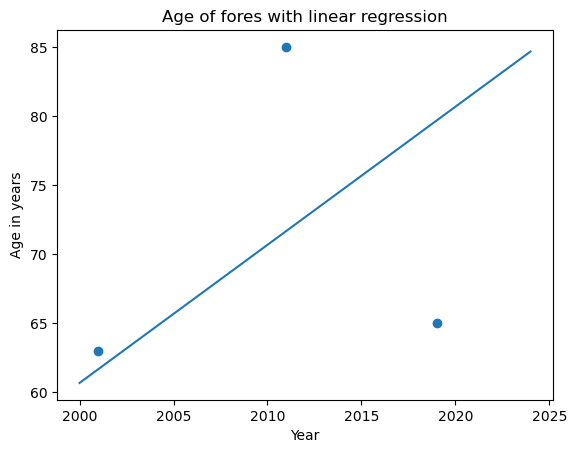

In [ ]:
ax = plt.scatter(x,y)
plt.title("Age of fores with linear regression")
plt.xlabel('Year')
plt.ylabel('Age in years')
plt.plot(x_int,y_int)

Our pipeline is good. We can now build a function

In [7]:

def linear_reg_fixed_slope(x_list,y_list,m):
    """This funciton takes in two arrays x and y, and a fixed slope and calculates the intercep b that best fits the data.
    This funciton only workd for linear regression, that is y=mx+b. x and y must be 1D arrays with same length.
    Parameters: 
        x_list: np.array of fixed x values
        y_list: np.array of y data values
        m: slope of linear regression, fixed
    Output:
        b: best b intercept for the given data
    """
    #get the indexes of not nan values
    z = (y_list-x_list*m)
    b = np.nanmean(z)
    
    return b

### Volumn Data Sigmoidal Interpolation

As previously explained, volume to age relationships can be deinfed as sigmoidal, with the following equation: [Y = a (1-exp(-bX))^m] where Y is the volume, A is age and a, b and m are coefficients. For our purpose, we will assume that one set of coefficient can be fitted for all of ontario. In technicality, some pockets of forests would have different coefficient based on species, but since we dont have that information we will assum one goverinng relationship. first lets explore how we can use scipy's [curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) function to fit coefficients.

In [3]:
y_vol = np.array([30,70,180],dtype='float')
y_vol

array([ 30.,  70., 180.])

We will use our interpolated data to calucalte the age of these volumes

In [4]:
x_vol_age = np.array([2001,2011,2015])

Generate the x-axis age for the volume years

In [5]:
x_vol = np.array([20,30,35])
x_vol

array([20, 30, 35])

The next function is our Chapmans curve definition

In [6]:
from scipy.optimize import curve_fit
def volume_age(x,a,b,m):
    """
    Function that takes in array and uses chapmans equation to calculate y (volume)
    Retuns single value or nparray
    """
    return (a*(1-np.exp(-b*x))**(m))

#this next function is redundant but was added and is integral to our code therfore must be included.

def vol_forest(x,a,b,m):
    """
    Funtion that takes in x array or values, a,b,m coefficients and passes them to volume_age function to reutrn y value or array
    """

    volume_age(x,a,b,m)
    return y

Now use curvefit to generate some coefficients.

In [ ]:


popt, pcov=curve_fit(volume_age,x_vol, y_vol, method='dogbox',bounds=((1,-20),(1000,-1)))

x_vol_fit = np.arange(1,200,1)
y_vol_fit = np.exp(volume_age(x_vol_fit,popt[0],popt[1]))
plt.plot(x_vol_fit,y_vol_fit)
plt.scatter(x_vol,np.exp(y_vol),color='red')
plt.title("Volume of forest with linear regression")
plt.xlabel('Year')
plt.ylabel('Volume in m^3/ha')

Now that we have a understanding of our process for volume, we can begine to approximate the coefficients. Originally, it was tourhg to fit the coeeficients to all the age and volume raw data, but that would be wrong since vol_2016 and age_2019 dont match, and on some rows we may have volume in vol_2001 but nan in age_2001. Also, we dont want to fit the coefficients to pixels that had fires or harvest as that would interfere with the volume vs. age relationship. Therfore lets filter the data to only have rows where there is data in 2001 and 2011, and no fires or harvest. Then we will randomly sample the data at difference increments, and get the best fit coefficients for each fit and take the average as our final coefficients.

In [ ]:
data_approx=data_approx[(~ON_forest_and_fires[['vol_2001','vol_2011','vol_2015']].isnull().any(axis=1)) & (data_approx['year_harvested'].isna() == True)& (data_approx['year'].isna() == True)]
data_approx.head()

We can create a funciton called return+coef_sigm which we can pass through to get best curve fit

In [ ]:


def return_coef_sig(x,y,start):
    """
    Funciton that takes in row of data from dataframe, and outpute the best fit for parameters a and b from sigmoidal expression defined in volume_age function
    :param data: row of data frame
    :return: parameters a, b
    """

    popt, pcov=curve_fit(volume_age,x, y, method='dogbox',p0=start,bounds=((1,0.0001,1),(float('inf'),1,float('inf'))),nan_policy='omit')

    a = popt[0]
    b = popt[1]

    return a,b,m


Now, loop through fractions of the data atleast 10 times each to see what coefficients it ouputs

In [ ]:
results =[]
fractions = np.array([0.01,0.02,0.05,0.1,0.15,0.2,0.3,0.4,0.5])
print(fractions)
for fraction in fractions:
    frac_datax,frac_datay,result = [],[],[]
    for i in range(10):
        temp = data.sample(frac=fraction)
        frac_datax.append(np.array(temp['age'],dtype='float'))
        frac_datay.append(np.array(temp['vol'],dtype='float'))
        result.append(return_coef_sig(np.array(temp['age'],dtype='float'),np.array(temp['vol'],dtype='float'),start = [250,0.5,10]))
        print(fraction,result[i])
    results.append(result)

[0.01 0.02 0.05 0.1  0.15 0.2  0.3  0.4  0.5 ]
0.01 (161.94953432388226, 0.0296937507669096, 3.7281452465344045)
0.01 (161.94953432388226, 0.0296937507669096, 3.7281452465344045)
0.01 (161.94953432388226, 0.0296937507669096, 3.7281452465344045)
0.01 (161.94953432388226, 0.0296937507669096, 3.7281452465344045)
0.01 (161.94953432388226, 0.0296937507669096, 3.7281452465344045)
0.01 (161.94953432388226, 0.0296937507669096, 3.7281452465344045)
0.01 (161.94953432388226, 0.0296937507669096, 3.7281452465344045)
0.01 (161.94953432388226, 0.0296937507669096, 3.7281452465344045)
0.01 (161.94953432388226, 0.0296937507669096, 3.7281452465344045)
0.01 (161.94953432388226, 0.0296937507669096, 3.7281452465344045)
0.02 (161.94953432388226, 0.0296937507669096, 3.7281452465344045)
0.02 (161.94953432388226, 0.0296937507669096, 3.7281452465344045)
0.02 (161.94953432388226, 0.0296937507669096, 3.7281452465344045)
0.02 (161.94953432388226, 0.0296937507669096, 3.7281452465344045)
0.02 (161.94953432388226, 0.0

Write into dataframe

In [ ]:
#Write into dataframe
list_fraction= []
for fraction in fractions:
    print(fraction)
    list_fraction.append(np.full(10,fraction))

a,b,m =[],[],[]
for i in results:
    for result in i:
        a.append(result[0])
        b.append(result[1])
        m.append(result[2])



Save and open when needed

In [ ]:
best_fit = pd.DataFrame({'sample_fraction':np.concatenate(list_fraction),'a':a,'b':b,'m':m},columns=['sample_fraction','a','b','m'])
best_fit.to_csv(r"I:\CME538 Project\CME538 Project\processed data ontario only\250m\Approximations\Summaries\vol_best_fit.csv")
best_fit=pd.read_csv(r"I:\CME538 Project\processed data ontario only\250m\Approximations\Summaries\vol_best_fit.csv")

In [14]:
a = best_fit['a'].mean()
b = best_fit['b'].mean()
m = best_fit['m'].mean()
print(a,b,m)

161.94953432388226 0.029693750766909603 3.728145246534403


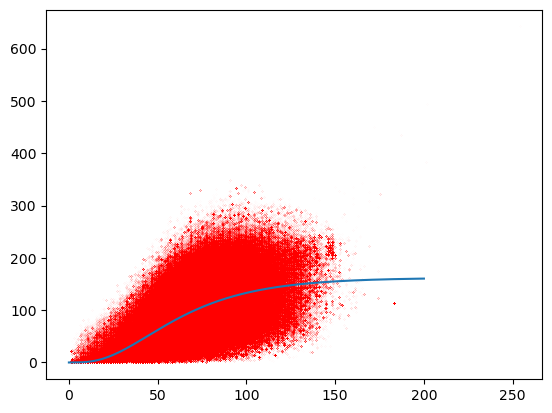

In [ ]:
x = np.arange(0.01,200,0.01)
y = volume_age(x,a,b,m)
temp = data.sample(frac = 0.2)
age = temp.age
vol = temp.vol

plt.plot(x,y)
plt.scatter(age,vol,color='red',s=0.0001)

 Now that we have our approximation functions and coefficients, we need to come up with a pipeline and some functions to go throught our data and generate the required information for each year. Lets remind oursleve of what our data looks like

In [ ]:
ON_forest_and_fires.head()

,age_2001,age_2011,age_2019,year_harvested,vol_2001,vol_2011,vol_2015,lon,lat,geometry,year,month,day,area_intersect_perc,number_fires
0,104.0,NaN,NaN,NaN,8.55,NaN,NaN,-84.890501,46.906052,POLYGON ((-84.88863710751139 46.90697579711416...,NaN,NaN,NaN,NaN,NaN
1,104.0,NaN,NaN,NaN,8.55,NaN,NaN,-84.885743,46.912303,POLYGON ((-84.88387922029249 46.91322718112671...,NaN,NaN,NaN,NaN,NaN
2,104.0,NaN,NaN,NaN,8.55,NaN,NaN,-84.887410,46.919261,POLYGON ((-84.88554623463179 46.92018483757417...,NaN,NaN,NaN,NaN,NaN
3,104.0,NaN,NaN,NaN,8.55,NaN,NaN,-84.884197,46.918908,POLYGON ((-84.88233307531861 46.91983171613633...,NaN,NaN,NaN,NaN,NaN
4,57.0,NaN,NaN,NaN,38.69,NaN,NaN,-84.748565,46.962634,POLYGON ((-84.74669588337325 46.96355596569322...,NaN,NaN,NaN,NaN,NaN


We want a dunction that will loop through each row, and get the relevant data and boundary/initial conditions for interpolation. To make things easier, lets build one that will get the initial conditions (harves, and fires), one that will get the information for age and one for volume.

   At the end, it would be ideal to have an array for each year that contains the age, volume, harvested or not, fire or not, and maybe percent burned to put in a  dataframe that looks like this, for each year

In [ ]:
pd.DataFrame(columns=['age','vol','harvested','burned','percent burned'])

,age,vol,harvested,burned,percent burned


Then, we will be able to look at each year, do some EDA, visualization and some machine learning to predict if a certain coordinate is succestible to a forest fire or not

Lets get going with our pipeline. As we can see, we have lists in columns that we need to loop through. Therfore we will have to pass each row of the dataframe into a funciton to approximate the age. Set let's us numpy to a little faster. Lets generate a funciton that can take our nested list and generate and array of arrays.

In [184]:
def convert_to_float(value):
    if isinstance(value, list):
        return np.array(value, dtype=float)
    elif isinstance(value, (int, float)):
        return float(value)
    else:
        return np.nan 


The following age_forest funciton takes in each row of the dataframe and generates an array from 1 to 252 months (21 years) of an apporoximation of age, the distrubance factor (area burned), and weather or not a fire or harvest occured. The code is summarized below with a figure.

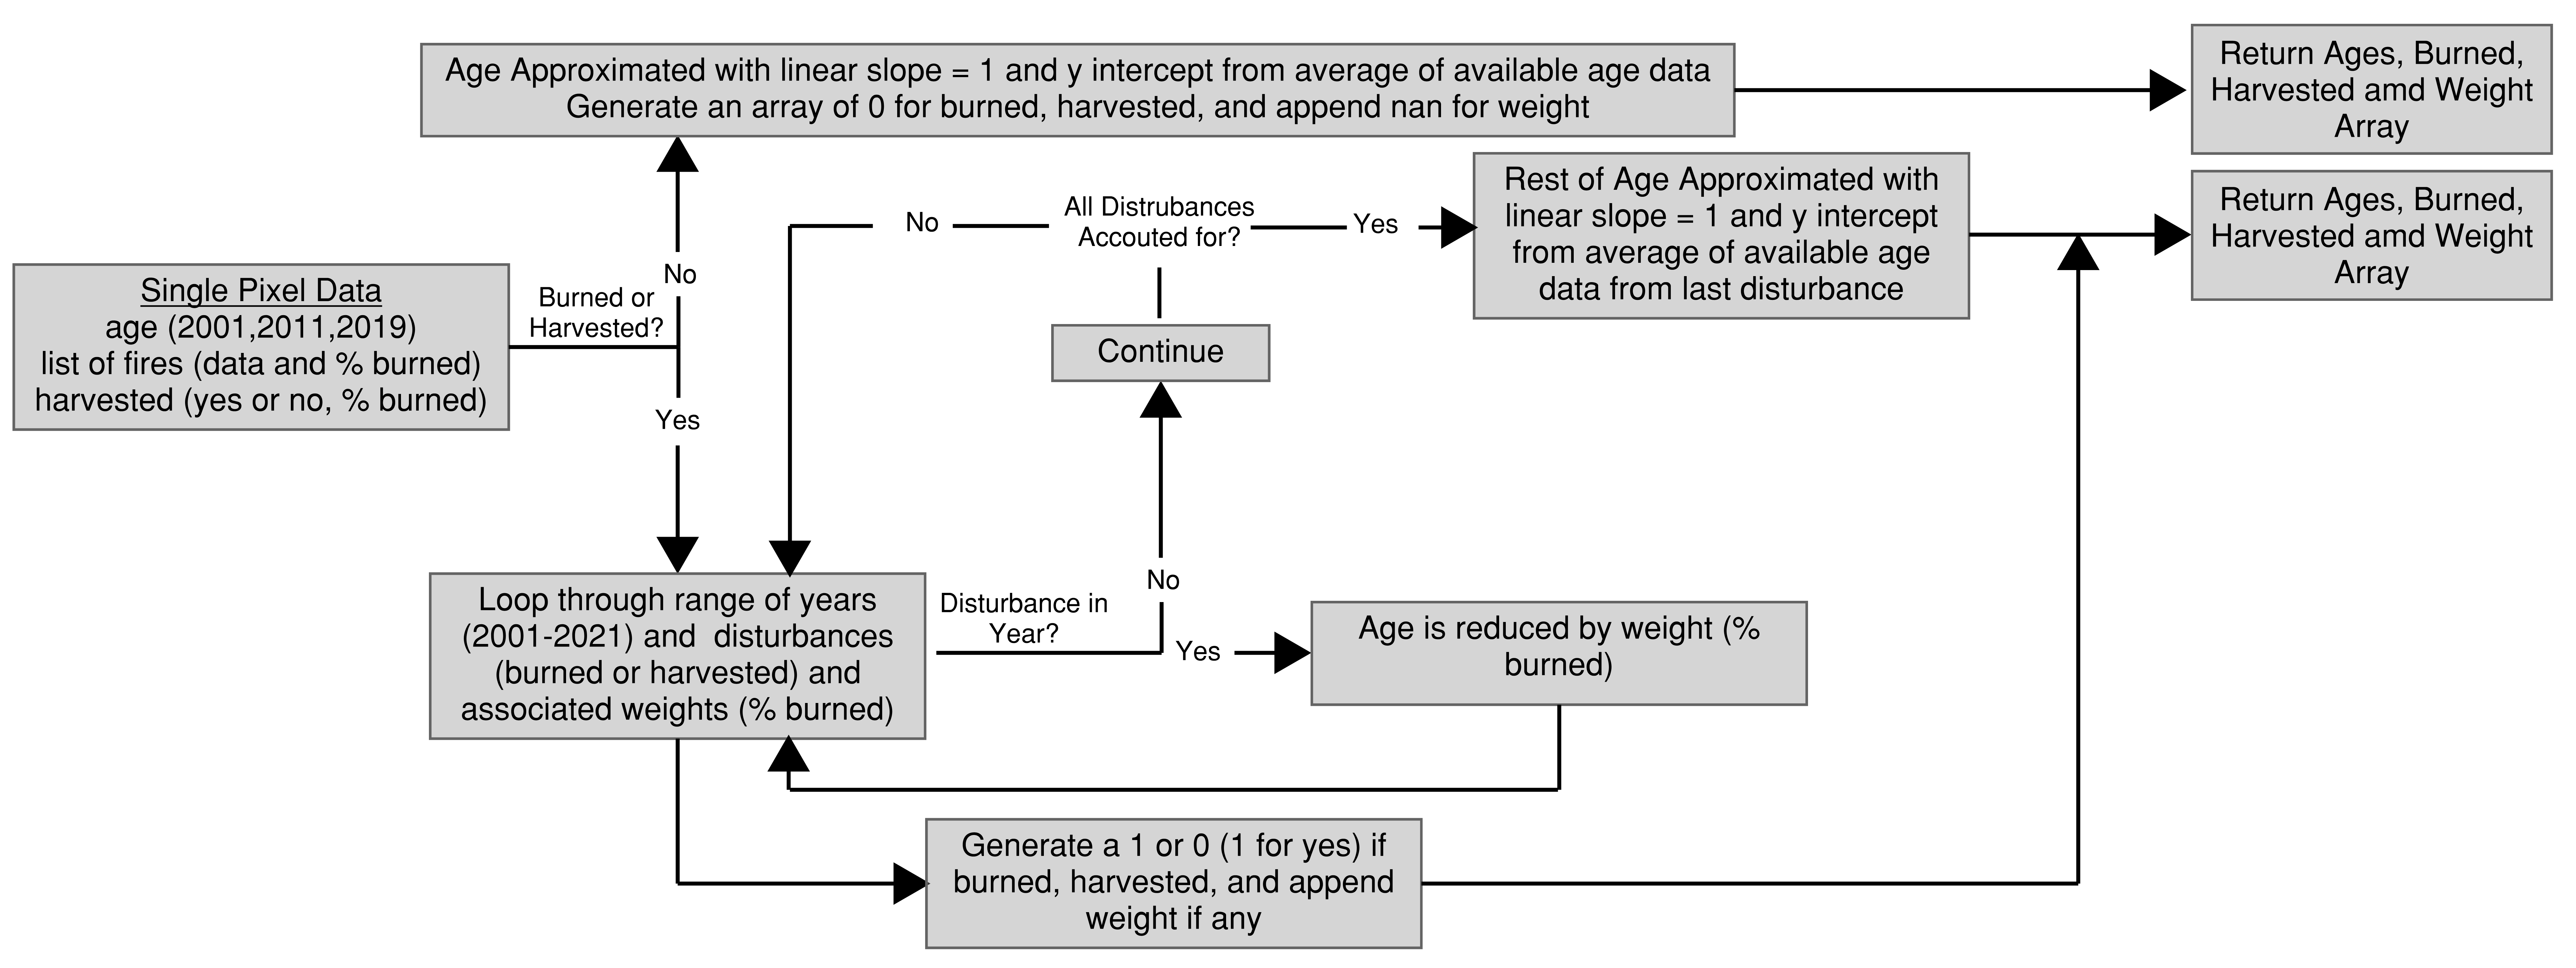

In [34]:

def age_forest(YEARS_1,YEARS_2,YEARS_3,HARVEST,FIREY,FIREM,DIST,NUMF,n_years,year_sep = 12):
    """
    """
    n_years = n_years
    
    #fix the slope, 1/12 here because we have our years+months as intergers, so years are factors of 12.
    m=1/12
    inc = 1/12
    #Firts condition is if there are no fires and no harvest
    if (str(NUMF[0]) == 'nan') & (str(HARVEST[0]) == 'nan'):
        
        #Calucluate mean interceps and 
        set_years = np.array([1,121,217])
        set_ages = np.append(np.append(YEARS_1,YEARS_2),YEARS_3)
        b = linear_reg_fixed_slope(set_years,set_ages,m)
        years = np.arange(1,n_years*12+1,1)
        
        #example here of if the intercep returned is nan, not enough data to approxiamte age, so return nan values.
        #this is in all the codeblocks below
        if str(b) != 'nan':
            ages = (years*m+b)
            harvested = np.zeros((n_years)*year_sep)
            fires = np.zeros((n_years)*year_sep)
            day = np.empty((n_years)*year_sep)
            day[:] = np.nan
            disturbance_weight = np.empty((n_years-1)*year_sep)
            disturbance_weight[:] = np.nan
            return ages,fires,harvested,disturbance_weight#,day,years
        #If data available, approxiamte age with no disturbances
        else:
            ages = np.empty((n_years)*year_sep)
            ages[:] = np.nan
            harvested = np.zeros((n_years)*year_sep)
            fires = np.zeros((n_years)*year_sep)
            day = np.empty((n_years)*year_sep)
            day[:] = np.nan
            disturbance_weight = np.empty((n_years)*year_sep)
            disturbance_weight[:] = np.nan
            return ages,fires,harvested,disturbance_weight#,day,years
        
    #next condition is if it was not harvested, but fires occured the next part of the codes gets all the distrubances
    #and associated weights (%burned) and adds them to a sorted array
    elif (str(NUMF[0]) != 'nan') | (str(HARVEST[0]) != 'nan'):
        
        #if there is no harves
        if str(HARVEST[0]) == 'nan':
            disturbance_years= (FIREY%100)*12-12
            disturbance_months = FIREM
            disturbance_years_months = disturbance_years+disturbance_months
            disturbance_factors = DIST
            
            disturbance_years_months, inv = np.unique(disturbance_years_months, return_inverse=True)      
            temp_df = np.zeros(len(disturbance_years_months), dtype=disturbance_factors.dtype)
            np.add.at(temp_df, inv, disturbance_factors)  
            disturbance_factors=temp_df
            

        #if there is no fires    
        elif str(NUMF[0]) == 'nan':
            disturbance_years= (HARVEST%100)*12-12
            disturbance_months = np.array([12])
            disturbance_years_months = disturbance_years + disturbance_months
            disturbance_factors = np.array([1])

        #if there are fires and harvest
        else:
            
            disturbance_years= (np.append(FIREY%100,HARVEST%100))*12-12
            disturbance_factors = np.append(DIST,1.0)
            disturbance_months = np.append(FIREM,12)
            
            disturbance_years_months = disturbance_years+disturbance_months
            
            disturbance_years_months, inv = np.unique(disturbance_years_months, return_inverse=True)      
            temp_df = np.zeros(len(disturbance_years_months), dtype=disturbance_factors.dtype)
            np.add.at(temp_df, inv, disturbance_factors)  
            disturbance_factors=temp_df


        #Create arrays of 1 and 0 for fires and harvest, and the month/day for the fire
        fires,harvested,disturbance_weight,day = [],[],[],[]
        j=0
        for i in np.arange(1,n_years*12+1,1):
            
            if i in disturbance_years_months.tolist():
                if i == ((HARVEST%100)*12-12+12):
                    harvested.append(1)
                    fires.append(0)
                    disturbance_weight.append(1)
                else:
                    fires.append(1)
                    #day.append(data['day'])
                    disturbance_weight.append(disturbance_factors[j])
                    harvested.append(0)
                    j = j+1
            else:
                fires.append(0)
                harvested.append(0)
                #day.append(np.nan)
                disturbance_weight.append(np.nan)
        year = 1
        #print("Starting new pixel at age {}".format(year))
        j=0

        #the next part of the funciton is what does the heavy lifting. It goes through all our 
        #coontraints in distrubance_year_months and generates the required avearged ages
        #depending on the conditons within certain ranges.

        for fire,area,month,i in zip(disturbance_years_months,disturbance_factors,disturbance_months,range(len(disturbance_years))):
            
            
            fire = float(fire)
            area = float(area)
            
            #For colume calculation, cannot have an age = 0 exactly
            if area > 1:
                area = 0.9999
                             
            
            if fire < 1:

                j=0
                continue
            #the rest of the code essentially goes all the disturbances and sees if they fit between years, and if they do,
            #the age from the years before the disturbance is approximated based on the average intercept,
            #and then the age is reduced by the weight of the disturbance, then the code continues throught the years
            
            #if disturbance is between 2001 and 2011
            elif (fire >= 1) & (fire < 121):
                if (i == 0) | (j==0):
                    set_years=np.array([1])
                    set_ages=YEARS_1
                    b = linear_reg_fixed_slope(set_years,set_ages,m)
                    if str(b) == 'nan':
                        years = np.arange(year,fire,1)
                        years[:] = np.nan
                        ages = (years*m+b)
                        year = fire
                        year_age = np.nan
                    else:
                        years = np.arange(year,fire,1)
                        ages = (years*m+b)
                        year = fire
                        year_age = int((fire*m+b)*(1-area))

                    j=1

                    continue
                else:
                    set_years=np.array([year])
                    set_ages=np.array([year_age])
                    b = linear_reg_fixed_slope(set_years,set_ages,m)
                    if str(b) == 'nan':
                        temp_years = np.arange(year,fire,1)
                        temp_years[:] = np.nan
                        years = np.append(years,temp_years)
                        ages = (years*m+b)
                        year = fire
                        year_age = np.nan
                    else:
                        temp_years = np.arange(year,fire,1)
                        years = np.append(years,temp_years)
                        ages = np.append(ages,(temp_years*m+b))
                        year = fire
                        year_age = int((fire*m+b)*(1-area))

                    j=1
                    continue
            #if disturbance is between 2011 and 2019
            elif (fire >= 121) & (fire < 217):
                if (i == 0) | (j==0):
                    set_years=np.array([1,121])
                    set_ages=np.append(YEARS_1,YEARS_2)
                    b = linear_reg_fixed_slope(set_years,set_ages,m)
                    if str(b) == 'nan':
                        years = np.arange(year,fire,1)
                        years[:] = np.nan
                        ages = (years*m+b)
                        year = fire
                        year_age = np.nan
                    else:
                        years = np.arange(year,fire,1)
                        ages = (years*m+b)
                        year = fire
                        year_age = int((fire*m+b)*(1-area))

                    j=1
                    continue
                else:
                    set_years=np.array([year])
                    set_ages=np.array([year_age])
                    b = linear_reg_fixed_slope(set_years,set_ages,m)
                    if str(b) == 'nan':
                        temp_years = np.arange(year,fire,1)
                        temp_years[:] = np.nan
                        years = np.append(years,temp_years)
                        ages = (years*m+b)
                        year = fire
                        year_age = np.nan
                    else:
                        temp_years = np.arange(year,fire,1)
                        years = np.append(years,temp_years)
                        ages = np.append(ages,(temp_years*m+b))
                        year = fire
                        year_age = int((fire*m+b)*(1-area))

                    j=1
                    continue
            
            #If fires are between 2019 and 2021
            elif (fire >= 217) & (fire < (n_years*12+1)):
                if (i == 0) | (j==0):
                    set_years=np.array([1,121,217])
                    set_ages=np.append(np.append(YEARS_1,YEARS_2),YEARS_3)
                    b = linear_reg_fixed_slope(set_years,set_ages,m)
                    if str(b) == 'nan':
                        years = np.arange(year,fire,1)
                        years[:] = np.nan
                        ages = (years*m+b)
                        year = fire
                        year_age = np.nan
                    else:
                        years = np.arange(year,fire,1)
                        ages = (years*m+b)
                        year = fire
                        year_age = int((fire*m+b)*(1-area))

                    j=1
                    continue
                else:
                    set_years=np.array([year])
                    set_ages=np.array([year_age])
                    b = linear_reg_fixed_slope(set_years,set_ages,m)
                    if str(b) == 'nan':
                        temp_years = np.arange(year,fire,1)
                        temp_years[:] = np.nan
                        years = np.append(years,temp_years)
                        ages = (years*m+b)
                        year = fire
                        year_age = np.nan
                    else:
                        temp_years = np.arange(year,fire,1)
                        years = np.append(years,temp_years)
                        ages = np.append(ages,(temp_years*m+b))
                        year = fire
                        year_age = int((fire*m+b)*(1-area))

                    j=1
                    continue
                
        #Once we have gone through all the distrubances, the rest of the funciton approximate the 
        #remaining age.
        
        if year < 121:
            set_years=np.array([year,121,217])
            set_ages=np.append(year_age,np.append(YEARS_2,YEARS_3))
            b = linear_reg_fixed_slope(set_years,set_ages,m)
            temp_years = np.arange(year,n_years*12+1,1)
            years = np.append(years,temp_years)
            ages = np.append(ages,(temp_years*m+b))
        elif (year >= 121) & (year < 217):

            set_years=np.array([year,217])
            set_ages=np.append(year_age,YEARS_3)
            b = linear_reg_fixed_slope(set_years,set_ages,m)
            temp_years = np.arange(year,n_years*12+1,1)
            years = np.append(years,temp_years)
            ages = np.append(ages,(temp_years*m+b))
        elif (year >= 217) & (year < (n_years*12+1)):

            set_years=np.array([year])
            set_ages=np.array(year_age)
            b = linear_reg_fixed_slope(set_years,set_ages,m)
            temp_years = np.arange(year,n_years*12+1,1)
            years = np.append(years,temp_years)
            ages = np.append(ages,(temp_years*m+b))

  
        return ages,fires,harvested,disturbance_weight#,day,years  
    
    
    

We can now use list comprehension to speed up our code a bit. At the end of a certain number or rows, the cvolume is calculated based on our predicted coefficients a,b,m and the approximated age. The data is then saved due to memory storage.

In [ ]:
#select the block size for saving on ram/storage
pixels = 15000000
num_blocks = 30
inter = 500000
ages,fires,harvests,dists = [],[],[],[]

#loop through all the blocks in data
for j in range(0,num_blocks):
    
    #conditions to establish where we are in data, and which data to use
    if j == (num_blocks-1):
        data = ON_forest_and_fires.iloc[j*inter:,:]
    elif j == 0:
        data = ON_forest_and_fires.iloc[j:inter,:]
    else:
        data = ON_forest_and_fires.iloc[j*inter:inter*(j+1),:]
    
    #pass the data as list comprehension to the function age_forest. this is faster then looping row by row through lists or
    #row by row through dataframe or using .apply. Or even usnig Dask.
    result = list(zip(*[age_forest(arr1,arr2,arr3,arr4,arr5,arr6,arr7,arr8,arr9,arr10)\
           for arr1, arr2, arr3, arr4, arr5, arr6, arr7, arr8, arr9, arr10\
              in zip(list(data['age_2001'].apply(convert_to_float)),
                     list(data['age_2011'].apply(convert_to_float)),
                     list(data['age_2019'].apply(convert_to_float)),
                     list(data['year_harvested'].apply(convert_to_float)),
                     list(data['year'].apply(convert_to_float)),
                     list(data['month'].apply(convert_to_float)),
                     list(data['area_intersect_perc'].apply(convert_to_float)),
                     list(data['number_fires'].apply(convert_to_float)),
                     np.full(len(data),21),
                     np.full(len(data),12))]))
    print("done block ",j)
    age,fire,harvest,dist = result


    #Calculate the volume based on age and coefficients
    vol = vol_forest(np.vstack(age),a,b,m)
    
    #Save all data 
    path = r"I:\CME538 Project\processed data ontario only\250m\Approximations\mod\\"
    col = list(np.arange(1,253,1).astype(str))
    pd.DataFrame(age,columns=col).to_feather(path+"ages_"+str(j)+".feather")
    pd.DataFrame(fire,columns=col).to_feather(path+"fires_"+str(j)+".feather")
    pd.DataFrame(vol,columns=col).to_feather(path+"vols_"+str(j)+".feather")
    pd.DataFrame(harvest,columns=col).to_feather(path+"harvested_"+str(j)+".feather")
    pd.DataFrame(dist,columns=col).to_feather(path+"disturbanceweight_"+str(j)+".feather")
    print("files are out")


